# SVM Models — Classification de la densité urbaine  
**Auteur :** Walid El Maataoui  
**Mini-projet :** 3  

Ce notebook compare plusieurs variantes de **SVM** (linéaire, RBF, polynomial), ajoute des **visuels**, applique une **validation croisée**, traite le **déséquilibre des classes** (class_weight / SMOTE) et réalise un **tuning** (GridSearchCV).  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Pour rendre les résultats reproductibles
RANDOM_STATE = 42


## 1) Chargement des données

In [2]:
# Chemin relatif (si le notebook est dans le même dossier que le CSV)
DATA_PATH = "geo_urban_density_data_preprocessed.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,densite_population,densite_batiments,hauteur_moy_bat,distance_centre_km,taux_impermeabilisation,longitude,latitude,classe_urbaine,wifi_density_probe,classe_urbaine_encoded,target
0,0.453399,-0.698912,2.843182,-1.272241,-0.430125,-6.051183,34.894106,moyenne,-1.901630,1,1
1,-0.211900,0.245391,-0.813133,-0.649780,1.170118,-6.081844,34.830155,moyenne,0.001375,1,1
2,0.611582,0.682685,0.561947,-1.026238,0.140410,-6.132758,35.022266,moyenne,0.001375,1,1
3,1.528722,1.333833,0.145990,1.440636,-1.334519,-6.009676,35.016155,faible,0.001375,0,0
4,-0.312351,0.937712,0.371744,0.629681,0.189653,-5.934113,35.099108,faible,0.001375,0,0


### Aperçu rapide  
On vérifie la taille du dataset, les colonnes disponibles et la variable cible.


In [3]:
print("Shape:", df.shape)
print("Colonnes:", list(df.columns))
print("\nRépartition des classes (target):")
print(df["classe_urbaine"].value_counts())


Shape: (1411, 11)
Colonnes: ['densite_population', 'densite_batiments', 'hauteur_moy_bat', 'distance_centre_km', 'taux_impermeabilisation', 'longitude', 'latitude', 'classe_urbaine', 'wifi_density_probe', 'classe_urbaine_encoded', 'target']

Répartition des classes (target):
classe_urbaine
faible               822
moyenne              449
zone_industrielle    114
elevee                14
industriel            12
Name: count, dtype: int64


## 2) Préparation des variables (X, y)

In [4]:
# Variables explicatives (features)
feature_cols = [
    "densite_population",
    "densite_batiments",
    "hauteur_moy_bat",
    "distance_centre_km",
    "taux_impermeabilisation",
    "wifi_density_probe",
]

# Variable cible
target_col = "classe_urbaine"

# Sélection
X = df[feature_cols].copy()
y = df[target_col].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1411, 6)
y shape: (1411,)


## 3) Split Train/Test (stratifié)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (1128, 6) (1128,)
Test : (283, 6) (283,)


## 4) Fonctions utilitaires (évaluation + visuels)

In [6]:
def plot_confusion_matrix(cm, class_names, title):
    """Affiche une matrice de confusion (heatmap simple avec matplotlib)."""
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    ax.set_ylabel("Vrai label")
    ax.set_xlabel("Label prédit")
    plt.tight_layout()
    plt.show()


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Entraîne, prédit, calcule accuracy/F1-macro + rapport + matrice."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-macro  : {f1m:.4f}")

    # Rapport de classification (par classe)
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()

    # Matrice de confusion
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plot_confusion_matrix(cm, labels, f"Matrice de confusion — {model_name}")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1_macro": f1m,
        "Report_df": report_df,
        "CM": cm,
        "Labels": labels,
        "Fitted_model": model,
        "y_pred": y_pred
    }


## 5) Modèles de base (linéaire, RBF, polynomial)

=== SVM linéaire ===
Accuracy : 0.8233
F1-macro  : 0.6210


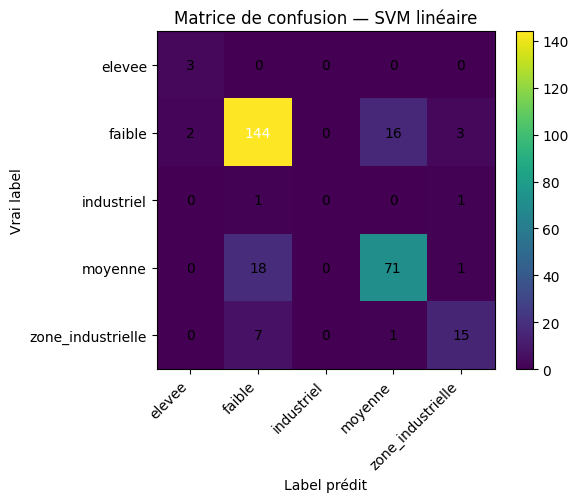

=== SVM RBF ===
Accuracy : 0.8975
F1-macro  : 0.5119


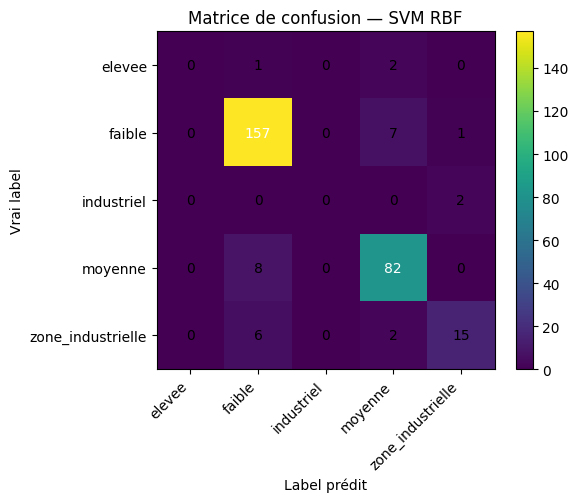

=== SVM polynomial (deg=3) ===
Accuracy : 0.8092
F1-macro  : 0.5556


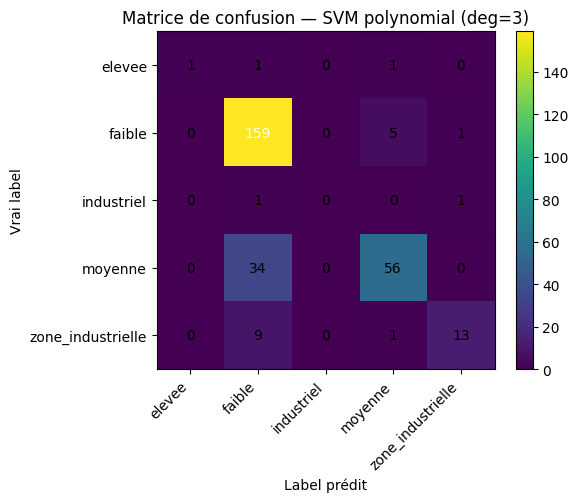

,Model,Accuracy,F1_macro
0,SVM linéaire,0.823322,0.621026
2,SVM polynomial (deg=3),0.809187,0.555605
1,SVM RBF,0.897527,0.511927


In [7]:
# Pipelines : Standardisation + SVC
svm_linear = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", random_state=RANDOM_STATE, probability=True))
])

svm_rbf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE, probability=True))
])

svm_poly = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", degree=3, random_state=RANDOM_STATE, probability=True))
])

results_baseline = []
results_baseline.append(evaluate_model(svm_linear, X_train, y_train, X_test, y_test, "SVM linéaire"))
results_baseline.append(evaluate_model(svm_rbf, X_train, y_train, X_test, y_test, "SVM RBF"))
results_baseline.append(evaluate_model(svm_poly, X_train, y_train, X_test, y_test, "SVM polynomial (deg=3)"))

summary_baseline = pd.DataFrame([
    {"Model": r["Model"], "Accuracy": r["Accuracy"], "F1_macro": r["F1_macro"]}
    for r in results_baseline
]).sort_values(by="F1_macro", ascending=False)

summary_baseline


### Comparaison visuelle (Accuracy vs F1-macro)

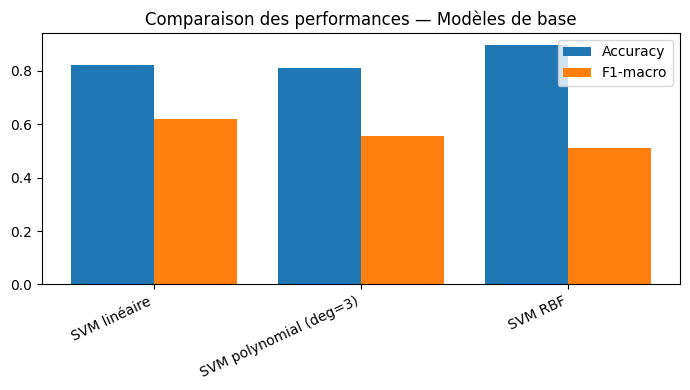

In [8]:
fig, ax = plt.subplots(figsize=(7,4))
x = np.arange(len(summary_baseline))
ax.bar(x - 0.2, summary_baseline["Accuracy"], width=0.4, label="Accuracy")
ax.bar(x + 0.2, summary_baseline["F1_macro"], width=0.4, label="F1-macro")
ax.set_xticks(x)
ax.set_xticklabels(summary_baseline["Model"], rotation=25, ha="right")
ax.set_title("Comparaison des performances — Modèles de base")
ax.legend()
plt.tight_layout()
plt.show()


## 6) Validation croisée (5-fold)

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_scores(model, X, y, name):
    scores = cross_validate(
        model, X, y, cv=cv,
        scoring={"acc":"accuracy", "f1m":"f1_macro"},
        n_jobs=-1
    )
    return {
        "Model": name,
        "CV_Accuracy_mean": scores["test_acc"].mean(),
        "CV_Accuracy_std": scores["test_acc"].std(),
        "CV_F1_macro_mean": scores["test_f1m"].mean(),
        "CV_F1_macro_std": scores["test_f1m"].std(),
    }

cv_results = []
cv_results.append(cv_scores(svm_linear, X, y, "SVM linéaire"))
cv_results.append(cv_scores(svm_rbf, X, y, "SVM RBF"))
cv_results.append(cv_scores(svm_poly, X, y, "SVM polynomial (deg=3)"))

cv_summary = pd.DataFrame(cv_results).sort_values(by="CV_F1_macro_mean", ascending=False)
cv_summary


,Model,CV_Accuracy_mean,CV_Accuracy_std,CV_F1_macro_mean,CV_F1_macro_std
0,SVM linéaire,0.829918,0.008475,0.621047,0.037501
2,SVM polynomial (deg=3),0.798709,0.017438,0.596649,0.019876
1,SVM RBF,0.897935,0.018729,0.549861,0.038984


## 7) Gestion du déséquilibre (class_weight vs SMOTE)

=== RBF + class_weight=balanced ===
Accuracy : 0.7774
F1-macro  : 0.5319


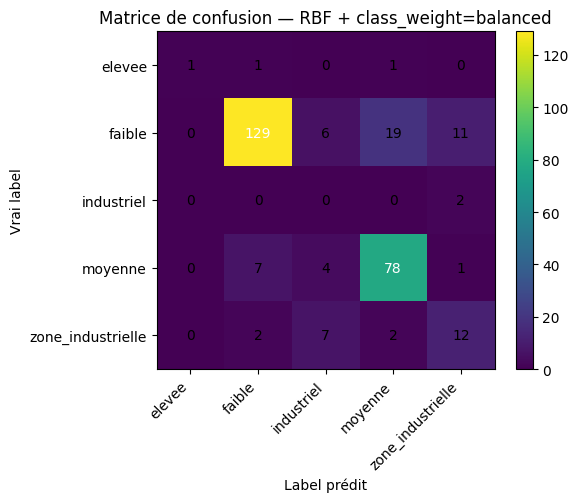

=== RBF + SMOTE ===
Accuracy : 0.8410
F1-macro  : 0.6261


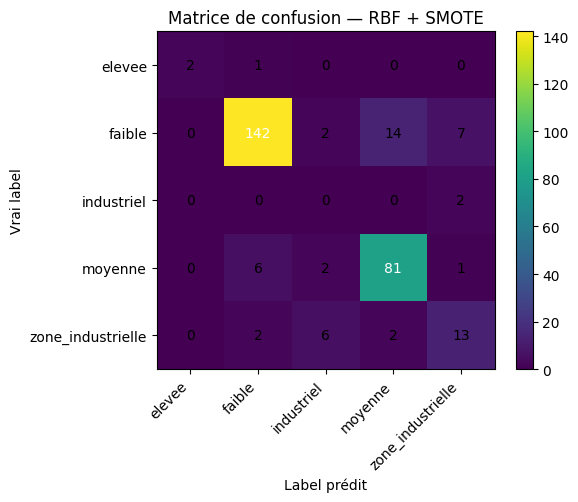

,Model,Accuracy,F1_macro
1,RBF + SMOTE,0.840989,0.626052
0,RBF + class_weight=balanced,0.777385,0.531907


In [10]:
# Variante 1 : class_weight='balanced' (SVC)
svm_rbf_balanced = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced", random_state=RANDOM_STATE, probability=True))
])

# Variante 2 : SMOTE + SVC (pipeline imblearn)
svm_rbf_smote = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE, probability=True))
])

results_imb = []
results_imb.append(evaluate_model(svm_rbf_balanced, X_train, y_train, X_test, y_test, "RBF + class_weight=balanced"))
results_imb.append(evaluate_model(svm_rbf_smote, X_train, y_train, X_test, y_test, "RBF + SMOTE"))

summary_imb = pd.DataFrame([
    {"Model": r["Model"], "Accuracy": r["Accuracy"], "F1_macro": r["F1_macro"]}
    for r in results_imb
]).sort_values(by="F1_macro", ascending=False)

summary_imb


## 8) Tuning (GridSearchCV) sur RBF

In [11]:
# On tune RBF (C, gamma) + option class_weight
param_grid = {
    "svm__C": [0.1, 1, 10, 50],
    "svm__gamma": ["scale", 0.1, 0.01, 0.001],
    "svm__class_weight": [None, "balanced"]
}

rbf_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE, probability=True))
])

grid = GridSearchCV(
    estimator=rbf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres:", grid.best_params_)
print("Meilleur score CV (F1-macro):", grid.best_score_)

best_rbf_tuned = grid.best_estimator_


Meilleurs paramètres: {'svm__C': 50, 'svm__class_weight': None, 'svm__gamma': 0.01}
Meilleur score CV (F1-macro): 0.6808271303851922


### Évaluation du meilleur modèle (tuned)

=== Meilleur RBF (tuned GridSearchCV) ===
Accuracy : 0.8799
F1-macro  : 0.6596


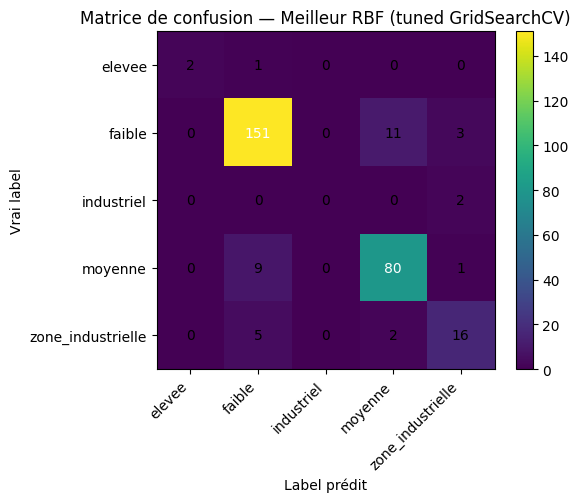

,precision,recall,f1-score,support
elevee,1.000000,0.666667,0.800000,3.000000
faible,0.909639,0.915152,0.912387,165.000000
industriel,0.000000,0.000000,0.000000,2.000000
moyenne,0.860215,0.888889,0.874317,90.000000
zone_industrielle,0.727273,0.695652,0.711111,23.000000
accuracy,0.879859,0.879859,0.879859,0.879859
macro avg,0.699425,0.633272,0.659563,283.000000
weighted avg,0.873629,0.879859,0.876282,283.000000


In [12]:
best_result = evaluate_model(best_rbf_tuned, X_train, y_train, X_test, y_test, "Meilleur RBF (tuned GridSearchCV)")
best_report = best_result["Report_df"]
best_report


### ROC-AUC (One-vs-Rest) — meilleur modèle

ROC-AUC macro   : 0.967976121115707
ROC-AUC weighted: 0.9645224767406091


<Figure size 800x600 with 0 Axes>

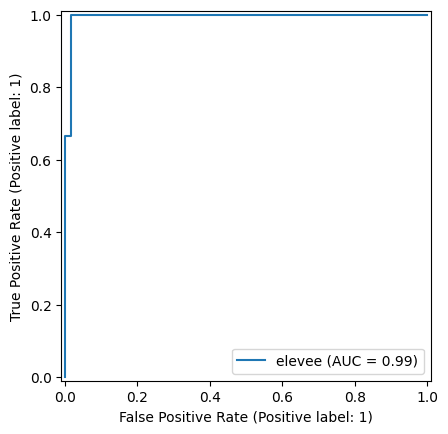

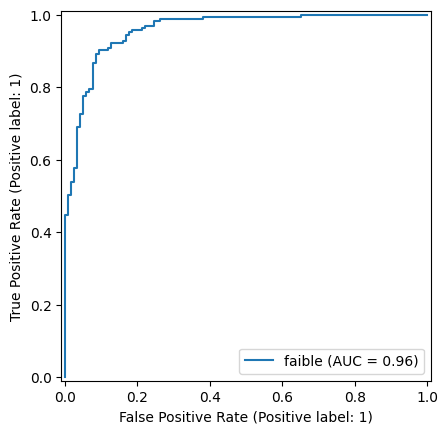

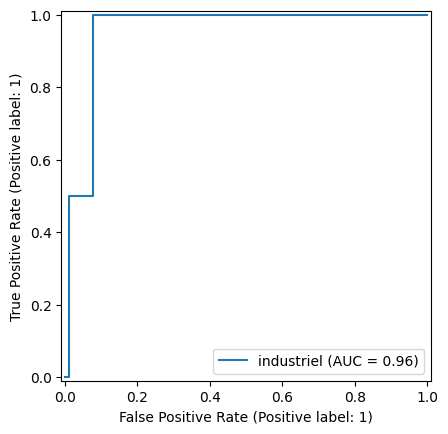

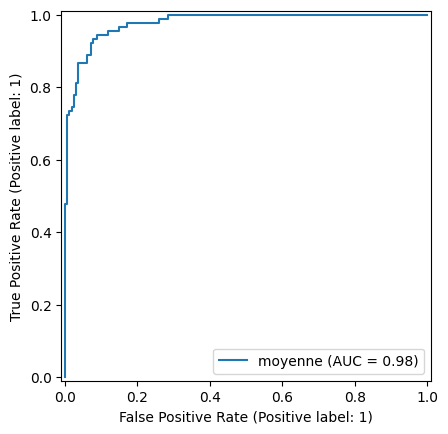

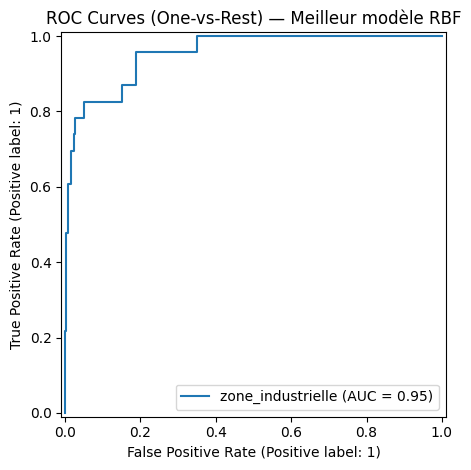

In [13]:
# ROC-AUC multi-classe (OvR)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

proba = best_rbf_tuned.predict_proba(X_test)
auc_macro = roc_auc_score(y_test_bin, proba, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_test_bin, proba, average="weighted", multi_class="ovr")

print("ROC-AUC macro   :", auc_macro)
print("ROC-AUC weighted:", auc_weighted)

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(y_test_bin[:, i], proba[:, i], name=str(cls))
plt.title("ROC Curves (One-vs-Rest) — Meilleur modèle RBF")
plt.tight_layout()
plt.show()


## 9) Importance des variables (Permutation Importance)

densite_population         0.338374
distance_centre_km         0.221111
taux_impermeabilisation    0.107462
hauteur_moy_bat            0.029159
densite_batiments          0.009915
wifi_density_probe         0.001484
dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_17216\3370606345.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(importances.index, rotation=25, ha="right")


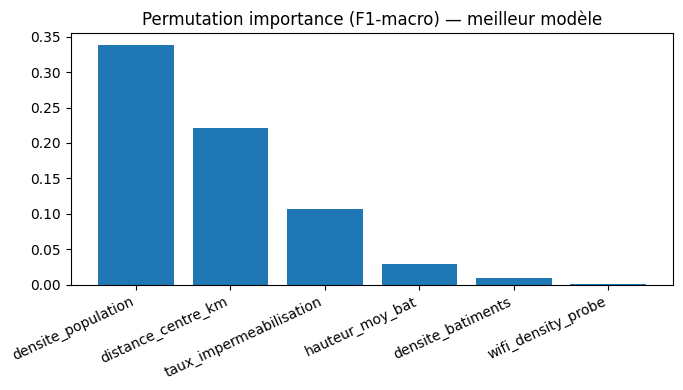

In [14]:
# Permutation importance sur le set de test (interprétabilité)
perm = permutation_importance(
    best_rbf_tuned, X_test, y_test,
    n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1,
    scoring="f1_macro"
)

importances = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)
print(importances)

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(importances.index, importances.values)
ax.set_title("Permutation importance (F1-macro) — meilleur modèle")
ax.set_xticklabels(importances.index, rotation=25, ha="right")
plt.tight_layout()
plt.show()


## 10) Sauvegarde des résultats (optionnel)

In [15]:
import os

OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

# Sauvegarde des tableaux de synthèse
summary_baseline.to_csv(os.path.join(OUT_DIR, "summary_baseline.csv"), index=False)
cv_summary.to_csv(os.path.join(OUT_DIR, "summary_cv.csv"), index=False)
summary_imb.to_csv(os.path.join(OUT_DIR, "summary_imbalance.csv"), index=False)
best_report.to_csv(os.path.join(OUT_DIR, "best_model_classification_report.csv"))

print("Fichiers sauvegardés dans:", OUT_DIR)


Fichiers sauvegardés dans: figures


## Conclusion

- Les **SVM de base** (linéaire / RBF / polynomial) donnent une première comparaison, mais la **F1-macro** révèle mieux la performance sur les classes minoritaires que l’accuracy seule.  
- La **validation croisée** confirme (ou nuance) la stabilité des performances.  
- Pour traiter le **déséquilibre**, **class_weight='balanced'** et **SMOTE** sont testés : l’objectif est d’améliorer la **F1-macro** sans trop dégrader la performance globale.  
- Le **tuning (GridSearchCV)** permet d’obtenir un **meilleur modèle RBF** optimisé selon **F1-macro**.  
- Les visuels (matrices de confusion, bar chart, ROC-AUC) rendent l’analyse plus claire et plus “rapportable”.

 
